## Can we predict the genre of a track using Spotify Data and ML ?

Project work for Module 3 – CAS Applied Data Science, University of Bern


Timothée Delapierre, december 2021


In [1]:
# This noteboook presents the module project for the CAS ADS (UniBE)
# The goal was to apply some of the course contents to another dataset
#
# For best results, run all the cells then launch the presentation using RISE

In [2]:
# Importing the necessary libraries for the project


import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, confusion_matrix

from time import time as timer

import numpy as np

import matplotlib.pyplot as plt


## Menu du jour

- First Idea
    - Data
        - Features
        - Target for classification
- New dataset ?
    - Collecting process
    - First attempts
    - Results
- Next steps



# First idea

Dataset on Kaggle with the top 2000 tracks on Spotify (from 1956 to 2019).

_Why not try to apply concepts from the ML class to it ?_

## Features
- **Index:** ID
- **Title:** Name of the Track
- **Artist:** Name of the Artist
- **Top Genre:** Genre of the track
- **Year:** Release Year of the track
- **Beats per Minute(BPM):** The tempo of the song
- **Energy:** The energy of a song - the higher the value, the more energtic. song
- **Danceability:** The higher the value, the easier it is to dance to this song.
- **Loudness:** The higher the value, the louder the song.
- **Valence:** The higher the value, the more positive mood for the song.
- **Length:** The duration of the song.
- **Acoustic:** The higher the value the more acoustic the song is.
- **Speechiness:** The higher the value the more spoken words the song contains
- **Popularity:** The higher the value the more popular the song is.



## Features
- <strike style="color:rgba(0,0,0,0.3)">**Index:** ID</strike>
- <strike>**Title:** Name of the Track</strike>
- <strike>**Artist:** Name of the Artist</strike>
- **Top Genre:** Genre of the track
- <strike>**Year:** Release Year of the track</strike>
- **Beats per Minute(BPM):** The tempo of the song
- **Energy:** The energy of a song - the higher the value, the more energtic. song
- **Danceability:** The higher the value, the easier it is to dance to this song.
- **Loudness:** The higher the value, the louder the song.
- **Valence:** The higher the value, the more positive mood for the song.
- **Length:** The duration of the song.
- **Acoustic:** The higher the value the more acoustic the song is.
- **Speechiness:** The higher the value the more spoken words the song contains
- <strike>**Popularity:** The higher the value the more popular the song is.</strike>



## How does this data look like



In [3]:
# The dataset can be found here on Kaggle (https://www.kaggle.com/iamsumat/spotify-top-2000s-mega-dataset)
# For the presentation, I'll host a copy on my server since Kaggle doesn't allow direct download

# Load the dataset in a Pandas.DataFrame
df_2000 = pd.read_csv('https://d1p.ch/data/Spotify-2000.csv',decimal=',')


# Removing features that aren't relevant
df_2000 = df_2000.iloc[:,3:]
df_2000 = df_2000.drop(columns=['year','popularity'])

# Let's have a look at the data
df_2000.head()

,top_genre,bpm,energy,danceability,loudness_dB,liveness,valence,duration_seconds,acousticness,speechiness
0,adult standards,157,30,53,-14,11,68,201.0,94,3
1,album rock,135,79,50,-11,17,81,207.0,17,7
2,alternative hip hop,168,69,66,-9,7,52,341.0,2,17
3,alternative metal,173,96,43,-4,3,37,269.0,0,4
4,classic rock,106,82,58,-5,10,87,256.0,1,3


In [4]:
df_2000.describe()

,bpm,energy,danceability,loudness_dB,liveness,valence,duration_seconds,acousticness,speechiness
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,120.215647,59.679539,53.238215,-9.008526,19.012036,49.408726,259.842122,28.858074,4.994985
std,28.028096,22.154322,15.351507,3.647876,16.727378,24.858212,81.944792,29.011986,4.401566
min,37.000000,3.000000,10.000000,-27.000000,2.000000,3.000000,1.121000,0.000000,2.000000
25%,99.000000,42.000000,43.000000,-11.000000,9.000000,29.000000,212.000000,3.000000,3.000000
50%,119.000000,61.000000,53.000000,-8.000000,12.000000,47.000000,245.000000,18.000000,4.000000
75%,136.000000,78.000000,64.000000,-6.000000,23.000000,69.750000,289.000000,50.000000,5.000000
max,206.000000,100.000000,96.000000,-2.000000,99.000000,99.000000,966.000000,99.000000,55.000000



### Task is classification with _top_genre_ as Y and the other features as X

In [5]:
genres_repartition = df_2000.top_genre.value_counts()

print(genres_repartition)

album rock           413
adult standards      123
dutch pop             88
alternative rock      86
dance pop             83
                    ... 
streektaal             1
indie anthem-folk      1
la pop                 1
ccm                    1
bebop                  1
Name: top_genre, Length: 149, dtype: int64


In [6]:
genres_repartition.describe()



count    149.000000
mean      13.382550
std       38.437664
min        1.000000
25%        1.000000
50%        3.000000
75%        9.000000
max      413.000000
Name: top_genre, dtype: float64

Having round 2000 samples and round 150 different classes doesn't sound very promising for a classification.

## Make my own dataset

From online readings about similar projects.


I held back from looking at similar projects beyond the introduction



Use **playlistmachinery.com** to get songs from playlists by genre
- The sound of Pop
- The sound of EDM
- The sound of Rock
- The sound of Hip hop

## Process
1. Find a playlist form a top trending genre
2. Load it into **sortyourmusic.playlistmachinery.com**
3. Extract the HTML table => Convert it to csv.

In [7]:
# Load the data from csv files
# Add a column because top genre isn't always the same
pop_df = pd.read_csv('https://d1p.ch/data/pop.txt')
pop_df['genre'] = 'pop'

edm_df = pd.read_csv('https://d1p.ch/data/edm.txt')
edm_df['genre'] = 'edm'

rock_df = pd.read_csv('https://d1p.ch/data/rock.txt')
rock_df['genre'] = 'rock'

hiphop_df = pd.read_csv('https://d1p.ch/data/hiphop.txt')
hiphop_df['genre'] = 'hip-hop'

dataframes = [pop_df, edm_df, rock_df, hiphop_df]


# Check the repartition between genres
print("Data repartition between genres :")
for df in dataframes:
    print(df['genre'].iloc[0], len(df.index))
          


# Merge the Dfs together
dfs = pd.concat(dataframes)

# Remove the uninteresting columns
dfs = dfs.iloc[:,8:]

# Shuffle the data
dfs = dfs.sample(frac=1).reset_index(drop=True) 

Data repartition between genres :
pop 1139
edm 942
rock 1171
hip-hop 968


In [8]:
dfs.describe()

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000,4220.000000
mean,120.759005,69.845735,62.899289,-6.715640,18.700237,50.728436,226.937204,15.822275,10.299052,64.419668
std,27.058862,18.066261,15.492333,2.933197,14.928873,22.917511,57.259091,21.482640,9.352903,12.168796
min,52.000000,8.000000,14.000000,-21.000000,1.000000,3.000000,121.000000,0.000000,2.000000,3.000000
25%,99.000000,58.000000,52.000000,-8.000000,9.000000,33.000000,188.000000,1.000000,4.000000,56.000000
50%,122.000000,72.000000,64.000000,-6.000000,13.000000,51.000000,217.000000,6.000000,6.000000,65.500000
75%,135.000000,84.000000,74.000000,-5.000000,24.000000,69.000000,256.000000,22.000000,13.000000,73.000000
max,211.000000,100.000000,98.000000,1.000000,98.000000,99.000000,592.000000,98.000000,48.000000,98.000000


In [9]:
feat_x = [
    'bpm',
    'nrgy',
    'dnce',
    'dB',
    'live',
    'val',
    'dur',
    'acous',
    'spch'
]

feat_y = ['genre']

df_x = dfs[feat_x].copy()
df_y = dfs[feat_y].copy()


# Label encoding
labelencoder = LabelEncoder()

df_y['genre_cat'] = labelencoder.fit_transform(df_y['genre'])

x = df_x.to_numpy().astype(np.float32)
y = df_y['genre_cat']



In [10]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


In [11]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


lsvc = LinearSVC(verbose=0, max_iter=1800, multi_class='ovr')

lsvc.fit(x_train, y_train)

score = lsvc.score(x_train, y_train)
testing_score = lsvc.score(x_test,y_test)
print("Training score: ", score)
print("Testing score: ", testing_score)

y_pred_lsvc = lsvc.predict(x_test)

print("\n### confusion matrix ###")
cm = confusion_matrix(y_test, y_pred_lsvc)
print(cm)

print("\n### classification report ###")
cr = classification_report(y_test, y_pred_lsvc)
print(cr)


Training score:  0.6954976303317536
Testing score:  0.6800947867298578

### confusion matrix ###
[[109  19  25  31]
 [  8 160  17  15]
 [ 38  29 132  36]
 [ 25   7  20 173]]

### classification report ###
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       184
           1       0.74      0.80      0.77       200
           2       0.68      0.56      0.62       235
           3       0.68      0.77      0.72       225

    accuracy                           0.68       844
   macro avg       0.68      0.68      0.68       844
weighted avg       0.68      0.68      0.68       844



In [12]:
classifier = KNeighborsClassifier(n_neighbors=40)
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=40)

In [13]:
y_pred_knn = classifier.predict(x_test)


print("\n### confusion matrix ###")
print(confusion_matrix(y_test, y_pred_knn))

print("\n### classification report ###")

print(classification_report(y_test, y_pred_knn))


### confusion matrix ###
[[122   7  27  28]
 [ 12 153  20  15]
 [ 40  20 155  20]
 [ 31   5  29 160]]

### classification report ###
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       184
           1       0.83      0.77      0.79       200
           2       0.67      0.66      0.67       235
           3       0.72      0.71      0.71       225

    accuracy                           0.70       844
   macro avg       0.70      0.70      0.70       844
weighted avg       0.70      0.70      0.70       844



In [14]:
error = []

# Calculating error for K values between 1 and 50
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

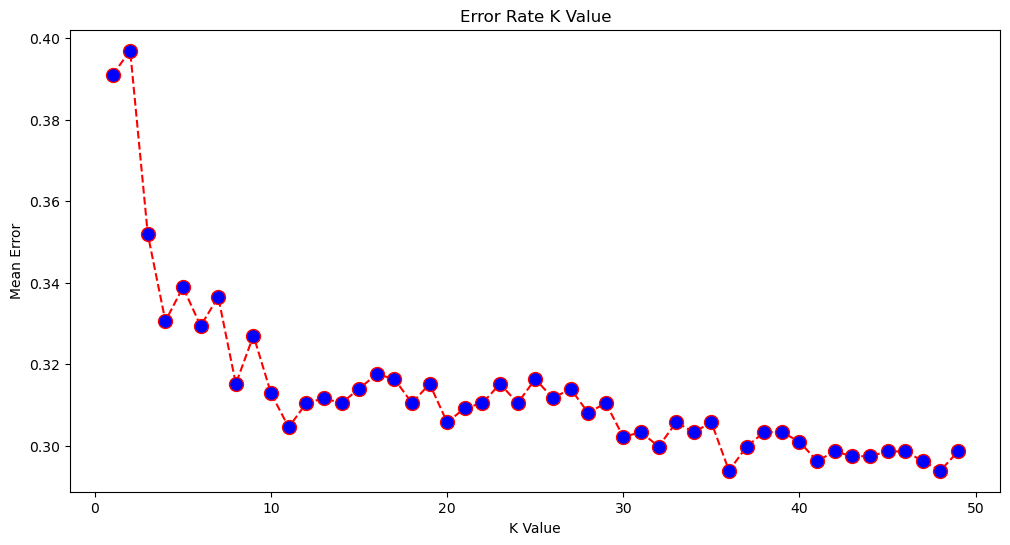

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 50), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

plt.show()


## Results

In [16]:
print("\n### confusion matrix (LSVC) ###")
cm = confusion_matrix(y_test, y_pred_lsvc)
print(cm)

print("\n### classification report (LSVC) ###")
cr = classification_report(y_test, y_pred_lsvc)
print(cr)

print("\n### confusion matrix (KNN) ###")
print(confusion_matrix(y_test, y_pred_knn))

print("\n### classification report (KNN) ###")

print(classification_report(y_test, y_pred_knn))


### confusion matrix (LSVC) ###
[[109  19  25  31]
 [  8 160  17  15]
 [ 38  29 132  36]
 [ 25   7  20 173]]

### classification report (LSVC) ###
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       184
           1       0.74      0.80      0.77       200
           2       0.68      0.56      0.62       235
           3       0.68      0.77      0.72       225

    accuracy                           0.68       844
   macro avg       0.68      0.68      0.68       844
weighted avg       0.68      0.68      0.68       844


### confusion matrix (KNN) ###
[[122   7  27  28]
 [ 12 153  20  15]
 [ 40  20 155  20]
 [ 31   5  29 160]]

### classification report (KNN) ###
              precision    recall  f1-score   support

           0       0.60      0.66      0.63       184
           1       0.83      0.77      0.79       200
           2       0.67      0.66      0.67       235
           3       0.72      0.71      0.71       225


# Conclusion

It's still interesting to be able to predict 7 out of 10 with round 4000 samples.

## Next steps

We'll need more data to increase the accuracy of the model.

Maybe take advantage of the **spotipy** library to extract more data.

Variety of _genre_ at Spotify is huge, need to find a way to generalize them into bigger categories

## Resources

### Datasets
- [Top 2000s Dataset](https://www.kaggle.com/iamsumat/spotify-top-2000s-mega-dataset)

### Documentation
- CAS ADS M3 - Tutorials
- [Sci-kit learn documentation](https://scikit-learn.org/stable/modules/classes.html)
- [Spotify API documentation](https://developer.spotify.com/documentation/web-api/reference/#/)
- <http://sortyourmusic.playlistmachinery.com>
- <https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/>

# Questions ?